In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

**MLE for time-inhomogenous OU processes**

We consider the time-inhomogeneous OU processes with the following SDE:

$dX_t = (-r(X_t - m(t)) + m'(t))dt + dW_t$

where $m(t) = \alpha ((t+1)^{\beta} - 1) + m_0$

This process possess mean-reverting property with its mean:

$E(X_t) = m(t)$

The code implements MLE for observations from from the time-inhomogenous OU processes. Their maximum likelihood is obtained by their tracatble transition densities

In [14]:
class OU:
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        
        beta_t = self.alpha * ((( self.pts[:-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[1:] + 1)**self.beta) - 1) + self.m0)

        for t in range(1, len(self.pts)):
            # if the distance is too small, variance becomes 0
            mean = (output[t-1] - beta_t[t-1]) * np.exp(-1 * self.r * interval[t-1] )
            sd = np.sqrt(((self.sigma ** 2) / (2*self.r)) * (1 - np.exp(-2 * self.r * interval[t-1])))
#             print(mean, sd)
            assert sd > 0, "standard deviation is negative, sd:%.3f interval: %.3f" % (sd, interval[t-1] )
            output[t] = ss.norm.rvs(loc = mean, scale = sd)
            
        return torch.from_numpy(output), interval

In [26]:
m0 = 1.7922
alpha = -0.633
beta = 3.5964
sigma = 1
r = 1.124

In [27]:
true_sde = OU(0, 2, m0, m0, alpha, beta, sigma, r, dN = 30)
true_sde_trj, true_sde_dt = true_sde.simulate()

In [28]:
func = lambda x: alpha * (((x + 1) ** beta) - 1) + m0

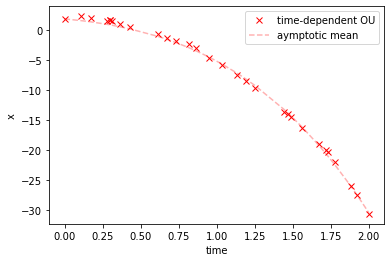

In [29]:
plt.plot(true_sde.pts, true_sde_trj, 'rx', label = 'time-dependent OU')
plt.plot(true_sde.pts, func(true_sde.pts), linestyle='dashed', color='red', alpha=0.3, label='aymptotic mean')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [30]:
class MLE:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        
        sigma = torch.tensor(self.ou.sigma)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
 
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[1:] - (X[:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
            return torch.sum( term1 - ((term2 ** 2) / term3))
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
        
        NLL.backward()
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Gradient descent algorithm is sensitive to initaliziation, in partciular, the sign of $\alpha$. Hence, it is better to initialize $\alpha$ around 0 so that the algorithm finds the right "direction"**

In [37]:
beta_ = torch.tensor([0.5], dtype=torch.float64)
alpha_ = torch.tensor([0.], dtype=torch.float64)
r_ =torch.tensor([1], dtype=torch.float64)

learning_rate = 0.000005
lr = learning_rate
for i in range(50000):
    mle = MLE(true_sde)
    update = mle.compute_score(beta = beta_, alpha=alpha_, m0=torch.tensor(m0), r=r_)
    beta_ +=  learning_rate * update['beta']
    alpha_ += learning_rate * update['alpha']
    r__ = r_ + learning_rate * update['r']
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ + lr * update['r']
        lr *= 0.5
    r_ = r__
        
    if i % 10000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'r = ', r_.data.numpy())
        print("MLE = ", update['LNN'])

beta =  [0.5] alpha =  [-0.00022311] r =  [0.99580361]
MLE =  -1008.2877449756535
beta =  [1.38419958] alpha =  [-0.95239712] r =  [0.00069161]
MLE =  -287.80311926273123
beta =  [2.95636742] alpha =  [-1.36468058] r =  [5.72138802e-06]
MLE =  12.078257971775557
beta =  [3.16274178] alpha =  [-1.05568384] r =  [2.98671675e-10]
MLE =  14.856553648260167
beta =  [3.34145607] alpha =  [-0.84648755] r =  [2.98671675e-10]
MLE =  16.388739659816537


In [32]:
print("true alpha = ", alpha, "true beta = ", beta, "true r = ", r)
print("fitted alpha= ", alpha_.data.numpy()[0], "fitted beta = ", beta_.data.numpy()[0], "fitted r = ", r_.data.numpy()[0])

true alpha =  -0.633 true beta =  3.5964 true r =  1.124
fitted alpha=  -0.7197075787459979 fitted beta =  3.473455356967867 fitted r =  2.9867167544669643e-10


In [33]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

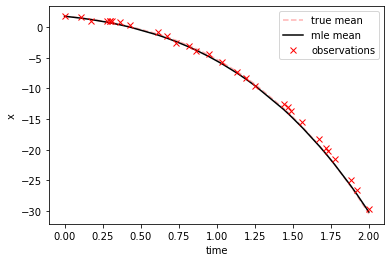

In [34]:
plt.plot(true_sde.pts, func(true_sde.pts), color='r', alpha=0.3, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts, post_mean(true_sde.pts), color='black', label="mle mean")
plt.plot(true_sde.pts, true_sde.trj, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

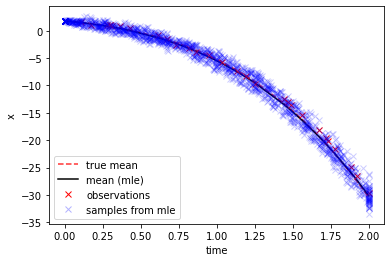

In [35]:
plt.plot(true_sde.pts, func(true_sde.pts), color='r', alpha=0.8, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts, post_mean(true_sde.pts), color='black', label="mean (mle)")
plt.plot(true_sde.pts, true_sde.trj, 'rx', label='observations')
for i in range(50):
    vi = OU(0, 2, m0, m0, alpha_, beta_, sigma, r_, dN = 30)
    plt.plot(vi.pts, vi.trj, 'bx', alpha=0.2)
    if i == 49:
        plt.plot(vi.pts, vi.trj, 'bx', alpha=0.3, label='samples from mle')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

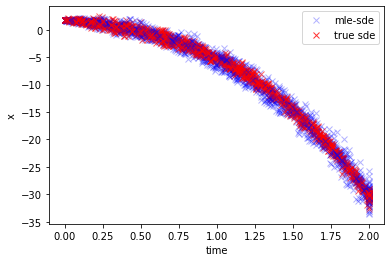

In [36]:
for i in range(50):
    vi = OU(0, 2, m0, m0, alpha_, beta_, sigma, r_, dN = 30)
    pr = OU(0, 2, m0, m0, alpha, beta, sigma, r, dN=30)
    plt.plot(vi.pts, vi.trj, 'bx', alpha=0.3)
    plt.plot(pr.pts, pr.trj, 'rx', alpha=0.6)
    
plt.plot(vi.pts, vi.trj, 'bx', alpha=0.3, label='mle-sde')
plt.plot(pr.pts, pr.trj, 'rx', alpha=0.8, label='true sde')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()